In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Ejercicio 1
## 1.

In [73]:
f = lambda x,A: 0.5*x.T@A@x
gf = lambda x,A: A@x
def met_gradiente(A, x0, lr=1, maxiter = 5000):
    # Cuando recibe lr=-1 elige algun paso_optim en (0, 1] al azar
    trayectoria = np.zeros((maxiter, A.shape[0]))
    trayectoria[0] = x0
    for i in range(1,maxiter):
        x = trayectoria[i-1]
        gradf = gf(x,A)
        if lr == -1:
            lr = np.random.rand(1)
        paso_optim = gradf.T@gradf/(gradf.T@A@gradf)
        trayectoria[i] = x - lr*paso_optim*gradf
    return trayectoria

In [74]:
def matcond(n, cond):
  # Q ortogonal, D diag. mal condicionada => QDQt mal condicionada
  D = np.linspace(1, cond, n)
  Q, _ = np.linalg.qr(np.random.randn(n, n))
  A = Q @ np.diag(D) @ Q.T
  return A

In [86]:
conds = 10**(np.linspace(4, 10, 5))
def test(met, ps, prom, conds = conds, n = 10):
  Eps = np.zeros((len(ps), len(conds)))
  x0 = np.array([4]*n)
  for i, p in enumerate(ps):
    for j, cond in enumerate(conds):
      for _ in range(prom):
        A = matcond(n, cond)
        trayectoria = met(A, x0, p)
        Eps[i, j] += f(trayectoria[-1], A)/prom # f se minimiza en f(0) = 0
  return Eps

In [76]:
def plt_test(Eps, ps, conds):
    for i in range(Eps.shape[0]):
        plt.plot(conds, Eps[i, :], ".--", label = f"p = {ps[i]}")
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel("condición")
    plt.ylabel("error")
    plt.legend()

La función ```test``` genera una matriz ```Eps```, que dado un parámetro del modelo y una condición, devuelve el error promedio del método del gradiente aplicado a ```prom``` matrices de 10x10

In [77]:
lrs1 = [0.25, 0.5, 0.75]
Eps1 = test(met_gradiente, lrs1, 20)
Epsr = test(met_gradiente, [-1], 12)

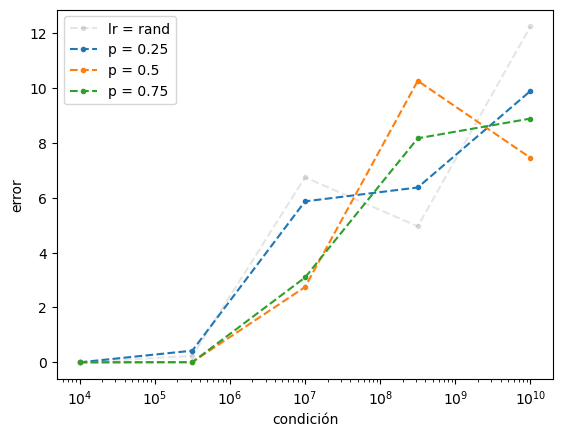

In [78]:
plt.plot(conds, Epsr[0], ".--", c = 'grey', alpha = 0.2, label = f"lr = rand")
plt_test(Eps1, lrs1, conds)

Usando la función de test que describimos, graficamos los errores para cada proporción de paso optimo en color.

## 2.

In [79]:
lrs2 = [1, 0.9, 0.99]
Eps2 = test(met_gradiente, lrs2, 20)

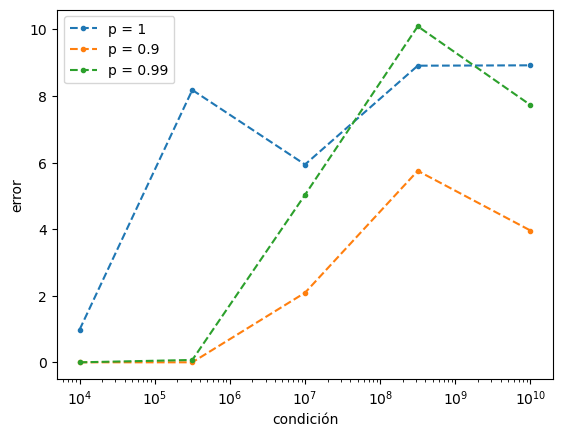

In [80]:
plt_test(Eps2, lrs2, conds)

## 3.

In [81]:
def matrot(t):
  return np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])

In [82]:
def met_gradiente_rot(A, x0, theta=0, maxiter = 5000):
    trayectoria = np.zeros((maxiter, A.shape[0]))
    trayectoria[0] = x0
    for i in range(1,maxiter):
        x = trayectoria[i-1]
        gradf_rot = matrot(theta) @ gf(x,A)
        paso_optim = gradf_rot.T@gradf_rot/(gradf_rot.T@A@gradf_rot)
        trayectoria[i] = x - paso_optim*gradf_rot
        if f(trayectoria[i], A) > f(trayectoria[i-1], A):
          gradf_rot = gf(x,A)
          paso_optim = gradf_rot.T@gradf_rot/(gradf_rot.T@A@gradf_rot)
          trayectoria[i] = x - paso_optim*gradf_rot

    return trayectoria

/tmp/ipykernel_63762/3001608586.py:7: RuntimeWarning: invalid value encountered in scalar divide
  paso_optim = gradf_rot.T@gradf_rot/(gradf_rot.T@A@gradf_rot)


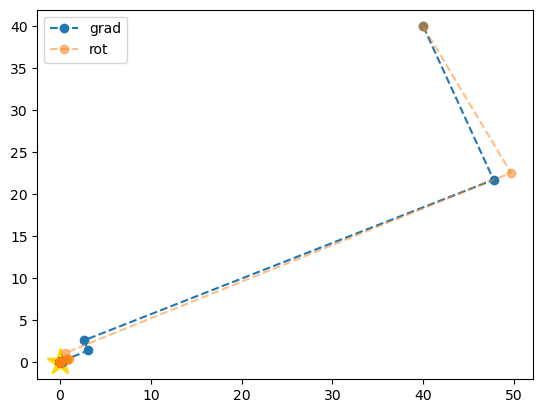

In [83]:
A = matcond(2,100)
x0 = np.array([40,40])

trayectoria_rot  = met_gradiente_rot(A, x0, theta = 1/30 * np.pi)
trayectoria_grad = met_gradiente(A, x0)

plt.plot([0,0],[0,0],'*',c='gold', ms = 20)

plt.plot(trayectoria_grad[:,0], trayectoria_grad[:,1], 'o--', label = 'grad')
plt.plot(trayectoria_rot[:,0], trayectoria_rot[:,1], 'o--', alpha = 0.5, label = 'rot')

plt.legend()

Acá graficamos una pequeña rotación. Se ve que no alcanza a romper del todo la ortogonalidad sucesiva entonces converge igual.

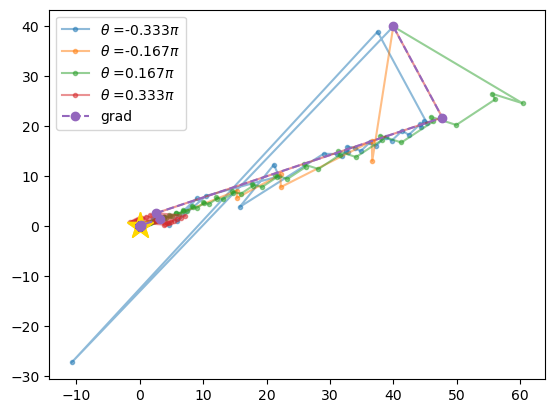

In [84]:
thetas = np.array([-1/3, -1/6, 1/6, 1/3]) * np.pi

for theta in thetas:
  trayectoria_rot  = met_gradiente_rot(A, x0, theta = theta)
  plt.plot(trayectoria_rot[:,0], trayectoria_rot[:,1], '.-', alpha = 0.5, label = r'$\theta$ ='+str(np.round(theta/np.pi,3))+r'$\pi$')

plt.plot([0,0],[0,0],'*',c='gold', ms = 20)

trayectoria_grad = met_gradiente(A, x0)
plt.plot(trayectoria_grad[:,0], trayectoria_grad[:,1], 'o--', label = 'grad')

plt.legend()

En el gráfico están todas las trayectorias pedidas. Para las rotaciones más grandes el método parece no converger.

In [87]:
Epsrot = test(met_gradiente_rot, thetas, 5, conds, 2)
plt_test(Epsrot, theta, conds)

IndexError: invalid index to scalar variable.

In [90]:
Epsrot.shape[0]

4

# Ejercicio 2
## 1.

In [ ]:
def met_gradiente_conj(A, x0, corr = False):
    maxiter = A.shape[0] + 1
    trayectoria = np.zeros((maxiter, A.shape[0]))
    trayectoria[0] = x0
    for i in range(1, maxiter):
        x = trayectoria[i-1]
        gradf = gf(x, A)
        if i == 1:
            d = gradf
        else:
            if corr:
                b = corr
            else:
                b = d.T@A@gradf/(d.T@A@d)
            d = -gradf + b*d
        paso_optim = d.T@gradf/(d.T@A@d)
        trayectoria[i] = x - paso_optim*d
    return trayectoria

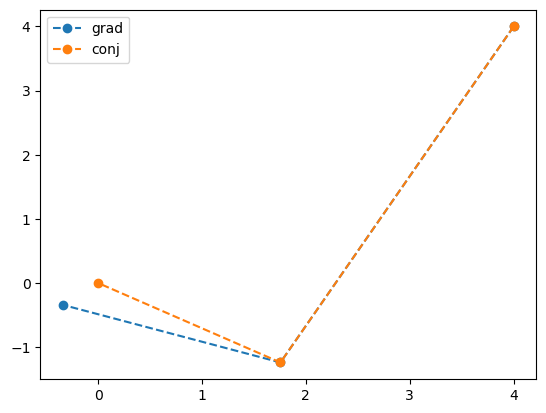

In [ ]:
A = np.array([[1, 2], [3, 4]])
trayectoria_grad = met_gradiente(A, np.array([4, 4]), maxiter = 3)
trayectoria_conj = met_gradiente_conj(A, np.array([4, 4]))

plt.plot(trayectoria_grad[:,0], trayectoria_grad[:,1], 'o--', label = 'grad')
plt.plot(trayectoria_conj[:,0], trayectoria_conj[:,1], 'o--', label = 'conj')
plt.legend()

El método del gradiente conjugado se aproxima al (0, 0) tras dos iteraciones, por tomar direcciones A-ortogonales, mientras que el método del gradiente tradicional le erra por un poquito.

In [ ]:
errs = np.zeros(102)
for n in range(2, 100):
    A = np.diag(np.random.rand(n)*10 - 5)
    trayectoria_conj = met_gradiente_conj(A, np.random.rand(n)*10 - 5)
    errs[0] = np.linalg.norm(trayectoria_conj[-1])

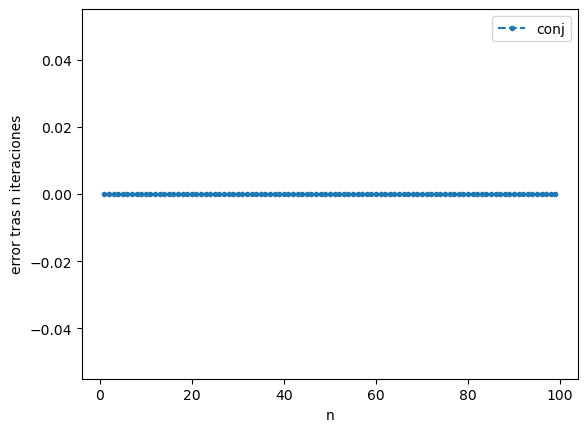

In [ ]:
plt.plot(range(1, 100), errs[3:], ".--", label = f"conj")
plt.xlabel('n')
plt.ylabel('error tras n iteraciones')
plt.legend()

La implementación del método del gradiente conjugado converge tras n iteraciones, que es el mínimo que un método podría tardar. Cabe destacar que estamos usando matrices diagonales, SPD.

## 2.

In [ ]:
factores = [(0.9, 1), (0.99, 1), (1, 0.9), (1, 0.99), (0.9, 0.9), (0.99, 0.99)]


NameError: name 'metGradConj' is not defined

Comentar cómo el desempeño de Gradientes Conjugados depende de la exactitud de la búsqueda lineal.

## 3.

In [ ]:
n = 1000
A = matcond(n, 100000)
b= np.zeros(n)
x0 = np.random.uniform(1, 100, n)

In [ ]:
x_conj, i = metGradConj(A, b, x0)
tray = met_gradiente(A, x0, maxiter  = i)

In [ ]:
np.linalg.norm(x_conj)

7.9515672615008e-10

In [ ]:
np.linalg.norm(tray[-1])

7.904868665796689e-10

# Ejercicio 3

In [ ]:
# EJERCICIO 3 - CHOLESKY

# Sea A simetrica definida positiva, efectúa la descomposición de Cholesky: devuelve L tal que A=L.Lt
def chol(A):
    n = A.shape[0]-1
    L = np.zeros(A.shape)
    L[0, 0] = np.sqrt(A[0, 0])

    for j in range(1, n+1):
        L[j, 0] = A[j, 0] / L[0, 0]

    for i in range(1, n+1):
        L[i, i] = np.sqrt(A[i, i] - sum(L[i, p]**2 for p in range(i)))
        if i != n:
            for j in range(i+1, n+1):
                L[j, i] = (A[j, i] - sum(L[i,p]*L[j,p] for p in range(i)))/ L[i, i]
    return L


# Sea L diagonal inferior, devuelve el resultado de Lx=b
def sust_forward(L, b):
    n = L.shape[0] - 1
    sol = np.zeros(L.shape[0])
    sol[0] = b[0]/L[0, 0]
    for i in range(1, n+1):
        sol[i] = (b[i] - sum(L[i,j]*sol[j] for j in range(i))) / L[i,i]
    return sol


# Sea L diagonal superior, devuelve el resultado de Lx=b
def sust_backward(L, b):
    n = L.shape[0] - 1
    sol = np.zeros(L.shape[0])
    sol[n] = b[n]/L[n, n]
    for i in reversed(range(n)):
        sol[i] = (b[i] - sum(L[i,j]*sol[j] for j in range(i+1,n+1))) / L[i,i]
    return sol

# Sea A simetrica definida positiva, devuelve el resultado de Ax=b
def eq_lineal_chol(A, b):
    L = chol(A)
    y = sust_forward(L, b)
    x = sust_backward(L.T, y)
    return x

In [ ]:
def newton_method_for_quadratic(hess, x0=None, tol=1e-3, max_iter=10):
    x = np.random.rand(hess.shape[0]) if x0 is None else x0
    for i in range(max_iter):
        grad = A @ x
        x_new = x - np.linalg.inv(hess) @ grad
        if f(x,A) < tol:
            return x_new, i
        x = x_new
        if i % round(max_iter*0.1) == 0:
          print(f"ya va el {100 * i/max_iter}%")
    print("Máximo número de iteraciones alcanzado.")
    return x, i



In [ ]:
A = np.load("/content/drive/MyDrive/LCD/IO/matriz.npy")
x0 = np.random.rand(A.shape[0])


FileNotFoundError: ignored

In [ ]:
x,i  = newton_method_for_quadratic(hess = A, x0=x0)
#np.linalg.norm(xmin) ,i
print(i)

In [ ]:
np.linalg.norm(x)